### This notebook contains analyses related to temporal filters and the distribution of CI.

All these analyses are described in the following sections of the main text:

- Appendix: Temporal Filtering
- Appendix: Identifying Influencers
- Appendix: Further Analysisù


In [1]:
import numpy as np
import networkx as nx
import pickle
import pandas as pd 
import glob
import json
import sys
import os
from tqdm import tqdm
import random


# Save the current working directory
current_directory = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join(current_directory, os.pardir)))

# Import libraries from the parent folder
import graph_tool.all as gt
from utilities import build_CI_rank, get_classes

# Return to the current working directory
os.chdir(current_directory)

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pickle
import pandas as pd
import graph_tool.all as gt
from  utilities import build_CI_rank,get_classes

retweet_net = '...'
bfs_path = '...'

validated_path = '...'
validated_path_with_dt = '...'

filtered_dt_path =  '...'

validated_networks = ['Left.gt','Right.gt','Full.gt','Full_only_lr.gt']

In [104]:
# Create a mapping of node information.

ver_to_id = {str(i): int(V.vp.id[i]) for i in V.vertices()}

# Add delta t as information to the edges.

In [2]:
filename0 = 'right_retweet_edges_dt.csv'

path_edges = '...'

edges_with_dt = pd.read_csv(path_edges + filename0, usecols=['auth_id', 'infl_id', 'delta_t'])

for filename in os.listdir(path_edges):

    if filename == filename0: continue        
    edges2 = pd.read_csv(path_edges + filename, usecols=['auth_id', 'infl_id', 'delta_t'])
    edges_with_dt = pd.concat([edges_with_dt, edges2])

del edges2

In [3]:
grouped_edges = edges_with_dt.groupby(['infl_id','auth_id']).agg({'delta_t': 'mean'})#.reset_index()

In [77]:
validated_networks = ['Full_only_lr.gt']

In [78]:
for i in range(len(validated_networks)):

    to_check = validated_networks[i]
    
    V = gt.load_graph(validated_path + to_check)

    # Creo un mapping delle informazioni sui nodi.
    ver_to_id = {str(i): int(V.vp.id[i]) for i in V.vertices()}
    
    delta_t_prop = V.new_edge_property("float")
    V.edge_properties['delta_t'] = delta_t_prop
    
    # Iterare su tutti gli edges e assegnare il valore di delta_t
    for edge in tqdm(V.edges()):
        # Ottieni i nodi sorgente e destinazione come stringhe
        targ_ = str(edge.target())
        sour_ = str(edge.source())
    
        # Ottieni l'ID dei nodi dai dizionari ver_to_id
        edge_ = (ver_to_id[sour_], ver_to_id[targ_])
    
        try:
            # Ottieni il valore delta_t dal DataFrame
            delta_t_value = grouped_edges.loc[edge_]['delta_t']
    
            # Assegna il valore alla proprietà delta_t dell'edge
            delta_t_prop[edge] = delta_t_value
        except KeyError:
            print(f"Edge {edge_} non trovato in grouped_edges")
    
            # Assegna il valore alla proprietà delta_t dell'edge
            delta_t_prop[edge] = 'None'
            continue
    
    
    file_name = to_check.split('.')[0] + '_with_dt.' + to_check.split('.')[1]
    
    
    V.save(validated_path_with_dt + file_name)

15230741it [21:45, 11665.74it/s]


['Full_with_dt.gt',
 'Full_only_lr_with_dt.gt',
 'Right_with_dt.gt',
 'Left_with_dt.gt']

### Remove connections that are above the 75th percentile.

In [103]:
# Function to remove connections with delta_t above the 75th percentile
def remove_high_percentile_edges(graph, delta_t_prop):
    edges_to_remove = set()

    for vertex in tqdm(graph.vertices()):
        delta_t_values = []

        # Collect all delta_t values for adjacent edges
        for edge in vertex.all_edges():
            delta_t_values.append(delta_t_prop[edge])

        if len(delta_t_values) > 1:
            # Calculate the 75th percentile
            threshold = np.percentile(delta_t_values, 75)

            # Remove edges with delta_t above the 75th percentile
            for edge in vertex.all_edges():
                if delta_t_prop[edge] > threshold:
                    edges_to_remove.add(edge)

    # Remove edges one by one
    for edge in edges_to_remove:
        graph.remove_edge(edge)


# Function to keep only the edge with the smallest delta_t for each node
def keep_minimum_delta_t_edge(graph, delta_t_prop):
    edges_to_keep = set()
    edges_to_remove = set()

    for vertex in tqdm(graph.vertices()):
        delta_t_values = []

        # Collect all delta_t values for adjacent edges and the edges themselves
        edges = list(vertex.all_edges())
        if len(edges) > 1:
            # Find the edge with the minimum delta_t
            min_edge = min(edges, key=lambda e: delta_t_prop[e])
            edges_to_keep.add(min_edge)

    # Remove edges that are not the ones with the minimum delta_t
    for edge in graph.edges():
        if edge not in edges_to_keep:
            edges_to_remove.add(edge)
            
    for edge in edges_to_remove:
        graph.remove_edge(edge)


In [104]:
import graph_tool.all as gt
import numpy as np
from tqdm import tqdm


path_1 = '...'

for file in os.listdir(validated_path_with_dt):

    V = gt.load_graph(validated_path_with_dt + file)
    
    # Assume the delta_t property exists on the edges
    delta_t_prop = V.ep['delta_t']    
    
    # Apply the function to the graph
    remove_high_percentile_edges(V, delta_t_prop)

    # Optionally apply the function to keep the edge with minimum delta_t
    #keep_minimum_delta_t_edge(V, delta_t_prop)
    
    # Save the modified graph
    V.save(path_1 + 'Filtered_' + file)


1937486it [05:38, 5724.37it/s]
1776399it [05:01, 5884.94it/s]
630818it [01:07, 9391.19it/s] 
936866it [02:15, 6927.76it/s]


In [17]:
import graph_tool.all as gt
import numpy as np
from tqdm import tqdm

for file in os.listdir(validated_path_with_dt):

    V = gt.load_graph(validated_path_with_dt + file)
    print(file,V.num_edges())
    
for file in os.listdir(filtered_dt_path):
    
    V = gt.load_graph(filtered_dt_path + file)
    print(file,V.num_edges())
    


Full_with_dt.gt 17171765
Full_only_lr_with_dt.gt 15230741
Right_with_dt.gt 2449246
Left_with_dt.gt 6536347
Filtered_Full_only_lr_with_dt.gt 917344
Filtered_Left_with_dt.gt 439737
Filtered_Full_with_dt.gt 1014599
Filtered_Right_with_dt.gt 296558


In [40]:
ls '...'

Full.gt  Full_only_lr.gt  Left.gt  Right.gt


In [122]:
V = gt.load_graph(validated_path  + 'Full_only_lr.gt')

In [1]:
bfs_path_1 = '...'
bfs_path_20 = '...'
bfs_path_75 = '.'

bfs_path_PNAS = '...'



bfs_info = pd.read_csv(path + 'Full_only_lr_bfs.csv')

NameError: name 'pd' is not defined

In [222]:
def analize_bfs_2(df):
    
    for step in range(3):
        
        if step == 0:
            print('Step 0:')
            # Filter data for the selected step
            filtered_data = df[df['Steps'] == step]
    
            filtered_data = add_percentage_column_and_filter(filtered_data)

            selected_rows = filtered_data[filtered_data['Sources'] == 'S']

            for index, row in selected_rows.iterrows():
                print(f'Sources: {row["Sources"]}, Target: {row["Targets"]} ,  Percentage: {row["Percentage"]:.1f}')
            print('\n')
        else:
            
            print(f'Step: {step}')
            # Filter data for the selected step
            filtered_data = df[df['Steps'] == step]
    
            filtered_data = add_percentage_column_and_filter(filtered_data)

            selected_rows = filtered_data[filtered_data['Targets'] == 'A']

            for index, row in selected_rows.iterrows():
                print(f'Sources: {row["Sources"]}, Target: {row["Targets"]} ,  Percentage: {row["Percentage"]:.1f}')

            print('\n')
    

def add_percentage_column_and_filter(df):
    # Calculate the total connections for each step
    df['Total_Connections'] = df.groupby('Steps')['Connections'].transform('sum')
    
    # Add a column with the percentage of total connections
    df['Percentage'] = (df['Connections'] / df['Total_Connections']) * 100
    
    # Filter rows with percentage above 1%
    filtered_df = df[df['Percentage'] > 1].drop(columns=['Total_Connections'])
    
    return filtered_df


def all_sides_and_steps(filtering_level):
    
    'filtering level: 0 = Original, 1 = taking 75% links, 2 = taking 20% links, 3 = only the fastest link'

    
    if filtering_level == 0:
        validated_bfs = ['Left_bfs.csv', 'Right_bfs.csv', 'Full_only_lr_bfs.csv']
    else:
        validated_bfs = ['Filtered_Left_with_dt_bfs.csv', 'Filtered_Right_with_dt_bfs.csv', 'Filtered_Full_only_lr_with_dt_bfs.csv']


    path = path_list[filtering_level]

    for number in range(3):
    
        to_check_original = validated_bfs[number]
        if filtering_level > 0:
            print(to_check_original.split('_')[1])
        else:
            print(to_check_original.split('_')[0])

        print(' ')
        to_check = validated_bfs[number]

        bfs_info = pd.read_csv(path + to_check)
        analize_bfs_2(bfs_info)


### BFS considering the filtering over delta t

In [227]:
all_sides_and_steps(3)

Left
 
step 0:
Sources: S, Target: A ,  Percentage: 99.2


step:  1
Sources: OLI, Target: A ,  Percentage: 15.9
Sources: I, Target: A ,  Percentage: 1.9
Sources: A, Target: A ,  Percentage: 81.6


step:  2
Sources: OL, Target: A ,  Percentage: 7.2
Sources: A, Target: A ,  Percentage: 92.3


Right
 
step 0:
Sources: S, Target: A ,  Percentage: 100.0


step:  1
Sources: A, Target: A ,  Percentage: 98.0


step:  2
Sources: OL, Target: A ,  Percentage: 1.1
Sources: OLI, Target: A ,  Percentage: 11.0
Sources: I, Target: A ,  Percentage: 13.4
Sources: A, Target: A ,  Percentage: 74.4


Full
 
step 0:
Sources: S, Target: A ,  Percentage: 99.9


step:  1
Sources: OL, Target: A ,  Percentage: 4.4
Sources: I, Target: A ,  Percentage: 9.4
Sources: A, Target: A ,  Percentage: 85.8


step:  2
Sources: OL, Target: A ,  Percentage: 3.9
Sources: OLI, Target: A ,  Percentage: 1.9
Sources: I, Target: A ,  Percentage: 2.7
Sources: A, Target: A ,  Percentage: 91.5




### Now check how many links, before the BFS, go from OL, I, OLI to Adp

In [4]:
validated_networks_new = ['Filtered_Left_with_dt.gt','Filtered_Right_with_dt.gt','Filtered_Full_only_lr_with_dt.gt']
validated_networks_original = ['Left.gt','Right.gt','Full_only_lr.gt']

validated_path_original = '...'
validated_path_1 = '...'
validated_path_20 = '...'
validated_path_75 =  '...'


number = 0
to_check_old = validated_networks_original[number]
to_check_new = validated_networks_new[number]


print(to_check_old)

Left.gt


In [9]:
def count_links(vertex, target_set):
    count = 0
    for e in vertex.in_edges():
        if int(e.source()) in target_set:
            count += 1
    return count


def get_percentage_without_BFS(V):

    # Save the current directory
    current_directory = os.getcwd()
    
    os.chdir('..')
    
    OL, OLI, I, A, S = get_classes(V, category='all', top=1000)
    
    # Return to the current directory (optional, if needed)
    os.chdir(current_directory)
    
    vertex_labels = V.vertex_properties["id"]
    
    id_to_index = {vertex_labels[v]: int(v) for v in V.vertices()}

    index_OL = {id_to_index[id_] for id_ in OL if id_ in id_to_index}
    index_ADP = {id_to_index[id_] for id_ in A if id_ in id_to_index}
    index_I = {id_to_index[id_] for id_ in I if id_ in id_to_index}
    index_OLI = {id_to_index[id_] for id_ in OLI if id_ in id_to_index}

    # Initialize counters
    link_coming_from_ADP = 0
    link_coming_from_OL = 0
    link_coming_from_I = 0
    link_coming_from_OLI = 0
    
    # Iterate over all nodes in the index_ADP set
    for v in index_ADP:
        vertex = V.vertex(v)
        link_coming_from_ADP += count_links(vertex, index_ADP)
        link_coming_from_OL += count_links(vertex, index_OL)
        link_coming_from_I += count_links(vertex, index_I)
        link_coming_from_OLI += count_links(vertex, index_OLI)

    print()
    # Print the results
    print("Links coming from ADP:", link_coming_from_ADP / V.num_edges())
    print("Links coming from OL:", link_coming_from_OL / V.num_edges())
    print("Links coming from I:", link_coming_from_I / V.num_edges())
    print("Links coming from OLI:", link_coming_from_OLI / V.num_edges())

    return

In [ ]:
number = 0
to_check_old = validated_networks_original[number]
to_check_new = validated_networks_new[number]


print(to_check_old)


V = gt.load_graph(validated_path_original + to_check_old)

get_percentage_without_BFS(V)

In [ ]:
#Right 

Link coming from ADP to ADP: 35.39%
Link coming from OL to ADP: 2.99%
Link coming from I to ADP: 27.17%
Link coming from OLI to ADP: 28.88%


#Left 

Link coming from ADP to ADP: 42.48%
Link coming from OL to ADP: 3.27%
Link coming from I to ADP: 17.62%
Link coming from OLI to ADP: 27.66%


#Full 

Link coming from ADP to ADP: 31.49%
Link coming from OL to ADP: 3.5%
Link coming from I to ADP: 23.75%
Link coming from OLI to ADP: 33.25%

### Top 0.1% for the CI

In [298]:
CI_out = V.vertex_properties["CI_out"]

CI_out_values = [CI_out[v] for v in V.vertices()]

In [303]:
# Calculate the threshold for the top 0.1%
threshold = np.percentile(CI_out_values, 99.9)

# Count the nodes that are in the top 0.1%
top_nodes = [v for v in V.vertices() if CI_out[v] >= threshold]
num_top_nodes = len(top_nodes)

# Print only the essential information
print(f"Threshold for the top 0.1%: {threshold}")
print(f"Number of nodes in the top 0.1%: {num_top_nodes}")

Soglia per il top 0.1%: 21931203.846005842
Numero di nodi nel top 0.1%: 631


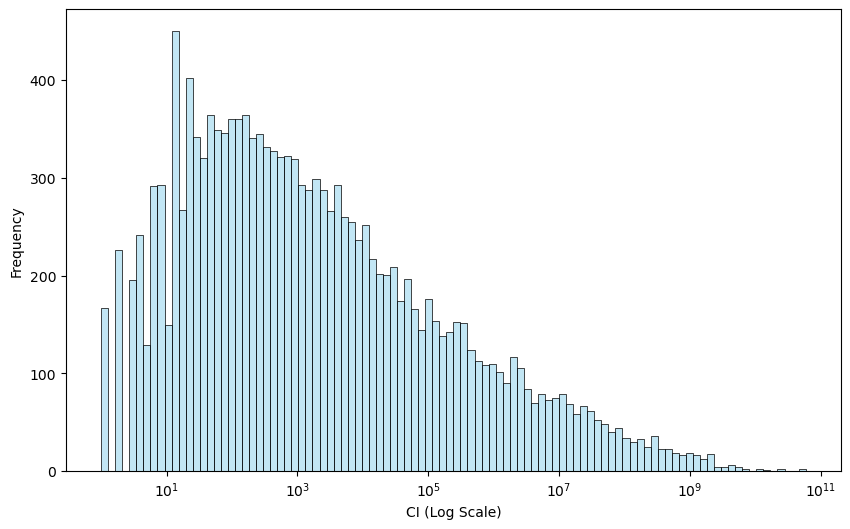

In [326]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(CI_out_values, bins=100, color='skyblue', kde=True, log_scale=(True, False))
#plt.title('Distribution of CI_out_values')
plt.xlabel('CI (Log Scale)')
plt.ylabel('Frequency')
#plt.grid(True)
plt.savefig('CI_distribution.pdf',format='pdf')
plt.show()



In [327]:
ls

BSF_With_time.ipynb  CI_distribution.pdf


### Here I calculate the percentage of connections that go to adopters

In [7]:
def get_percentage_without_BFS_to_adps(V):

    # Save the current directory
    current_directory = os.getcwd()
    
    os.chdir('..')
    
    OL, OLI, I, A, S = get_classes(V, category='all', top=1000)
    
    # Return to the current directory (optional, if needed)
    os.chdir(current_directory)
    
    vertex_labels = V.vertex_properties["id"]
    
    id_to_index = {vertex_labels[v]: int(v) for v in V.vertices()}

    index_OL = {id_to_index[id_] for id_ in OL if id_ in id_to_index}
    index_ADP = {id_to_index[id_] for id_ in A if id_ in id_to_index}
    index_I = {id_to_index[id_] for id_ in I if id_ in id_to_index}
    index_OLI = {id_to_index[id_] for id_ in OLI if id_ in id_to_index}

    # Initialize counters
    link_coming_from_ADP_OL = 0
    link_coming_from_ADP_I = 0
    link_coming_from_ADP_OLI = 0
    
    # Iterate over all nodes in the index_OL set
    for v in index_OL:
        vertex = V.vertex(v)
        link_coming_from_ADP_OL += count_links(vertex, index_ADP)
        
    # Iterate over all nodes in the index_I set
    for v in index_I:
        vertex = V.vertex(v)
        link_coming_from_ADP_I += count_links(vertex, index_ADP)
        
    # Iterate over all nodes in the index_OLI set
    for v in index_OLI:
        vertex = V.vertex(v)
        link_coming_from_ADP_OLI += count_links(vertex, index_ADP)

    print()
    # Print the results
    print("Links coming from OL:", link_coming_from_ADP_OL / V.num_edges())
    print("Links coming from I:", link_coming_from_ADP_I / V.num_edges())
    print("Links coming from OLI:", link_coming_from_ADP_OLI / V.num_edges())
    
    return


In [10]:
number = 2
to_check_old = validated_networks_original[number]
to_check_new = validated_networks_new[number]


print(to_check_old)


V = gt.load_graph(validated_path_original + to_check_old)

get_percentage_without_BFS_to_adps(V)

Full_only_lr.gt
N° Influencers: 403
N° OL: 1184
N° OLI: 511
N° Sources: 259
N° Adopters: 1774053
Number of nodes does not sum to the total!

Link coming from OL: 0.0005590666928155367
Link coming from I: 0.0005653040781141246
Link coming from OLI: 0.00039735427186372613


In [ ]:
# Left

Link coming from ADPs to OL: 0.09262054171848587  %
Link coming from ADPs to I: 0.15306714897480199 %
Link coming from ADPs to OLI: 0.09485420526174636 %


# Right

Link coming from ADPs to OL: 0.05548646399749147 %
Link coming from ADPs to I: 0.4571202729329761 %
Link coming from ADPs to OLI: 0.03098912889926124 %

# Full

Link coming from ADPs to OL: 0.05590666928155367 %
Link coming from ADPs to I: 0.05653040781141246 %
Link coming from ADPs to OLI: 0.039735427186372613 %